# Context
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

# Content
It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:
```
Age (numeric)
Sex (text: male, female)
Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
Housing (text: own, rent, or free)
Saving accounts (text - little, moderate, quite rich, rich)
Checking account (numeric, in DM - Deutsch Mark)
Credit amount (numeric, in DM)
Duration (numeric, in month)
Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
```
# Acknowledgements
- Source: UCI
- Kaggle: https://www.kaggle.com/uciml/german-credit#german_credit_data.csv

In [1]:
import pandas as pd
import numpy as np
from fairml import audit_model
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 10]

In [2]:
df = pd.read_csv("./german_credit_data_with_risk.csv")
df.head(20)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
5,5,35,male,1,free,NaN,NaN,9055,36,education,good
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,7,35,male,3,rent,little,moderate,6948,36,car,good
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,9,28,male,3,own,little,moderate,5234,30,car,bad


In [3]:
from data_processing import preprocess_german_credit_scoring
df = preprocess_german_credit_scoring(df)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,2,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,2,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0


# Entrenando el modelo

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df.drop("Risk", axis=1)
y = df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train simple model
model = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'  accuracy: {accuracy_score(y_test, y_pred):.2f}%')

  accuracy: 0.76%


/home/alicia/workspace/ml_bias/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Permutation importance

In [5]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

feature_names=X.columns.tolist()

show_weights(PermutationImportance(model).fit(X_test, y_test), feature_names=feature_names)

Weight,Feature
0.0670 ± 0.0367,Checking account
0.0520 ± 0.0150,Duration
0.0060 ± 0.0214,Saving accounts
-0.0010 ± 0.0147,Job
-0.0030 ± 0.0102,Housing
-0.0060 ± 0.0117,Credit amount
-0.0060 ± 0.0279,Sex
-0.0080 ± 0.0150,Purpose
-0.0160 ± 0.0279,Age


## Partial Dependence Plots

Available features: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']


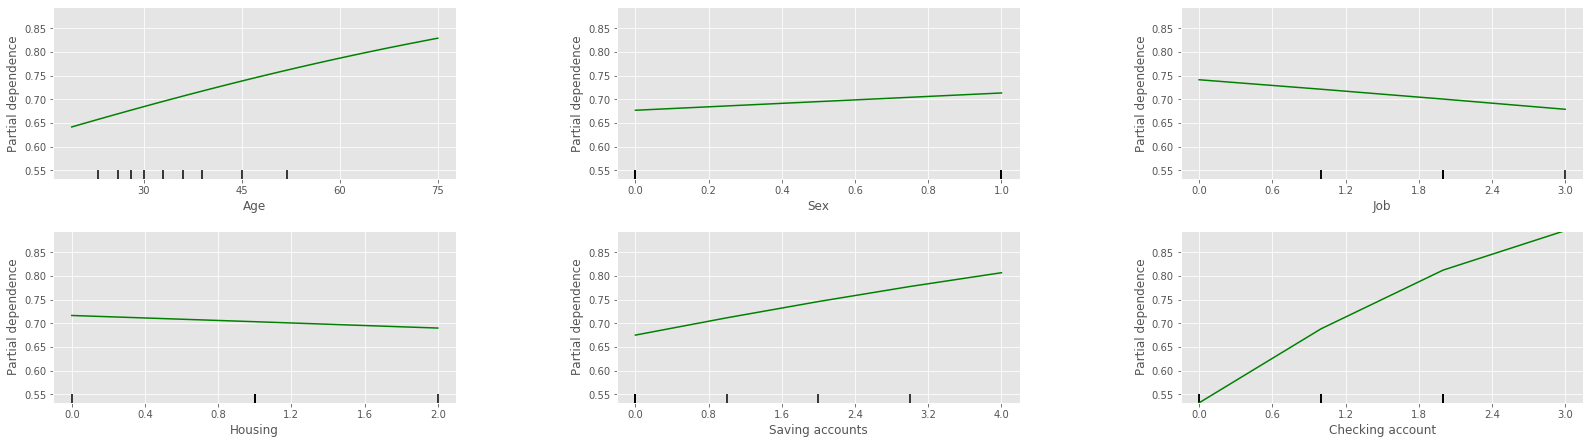

In [6]:
from sklearn.inspection import plot_partial_dependence

print(f'Available features: {df.columns.to_list()}')

plot_partial_dependence(
    model, 
    X=X,  # raw predictors data
    features=[0,1,2,3,4,5],  # column numbers of plots we want to show
    feature_names=feature_names,   # labels on graphs
    n_cols=3,
    grid_resolution=100,
) 

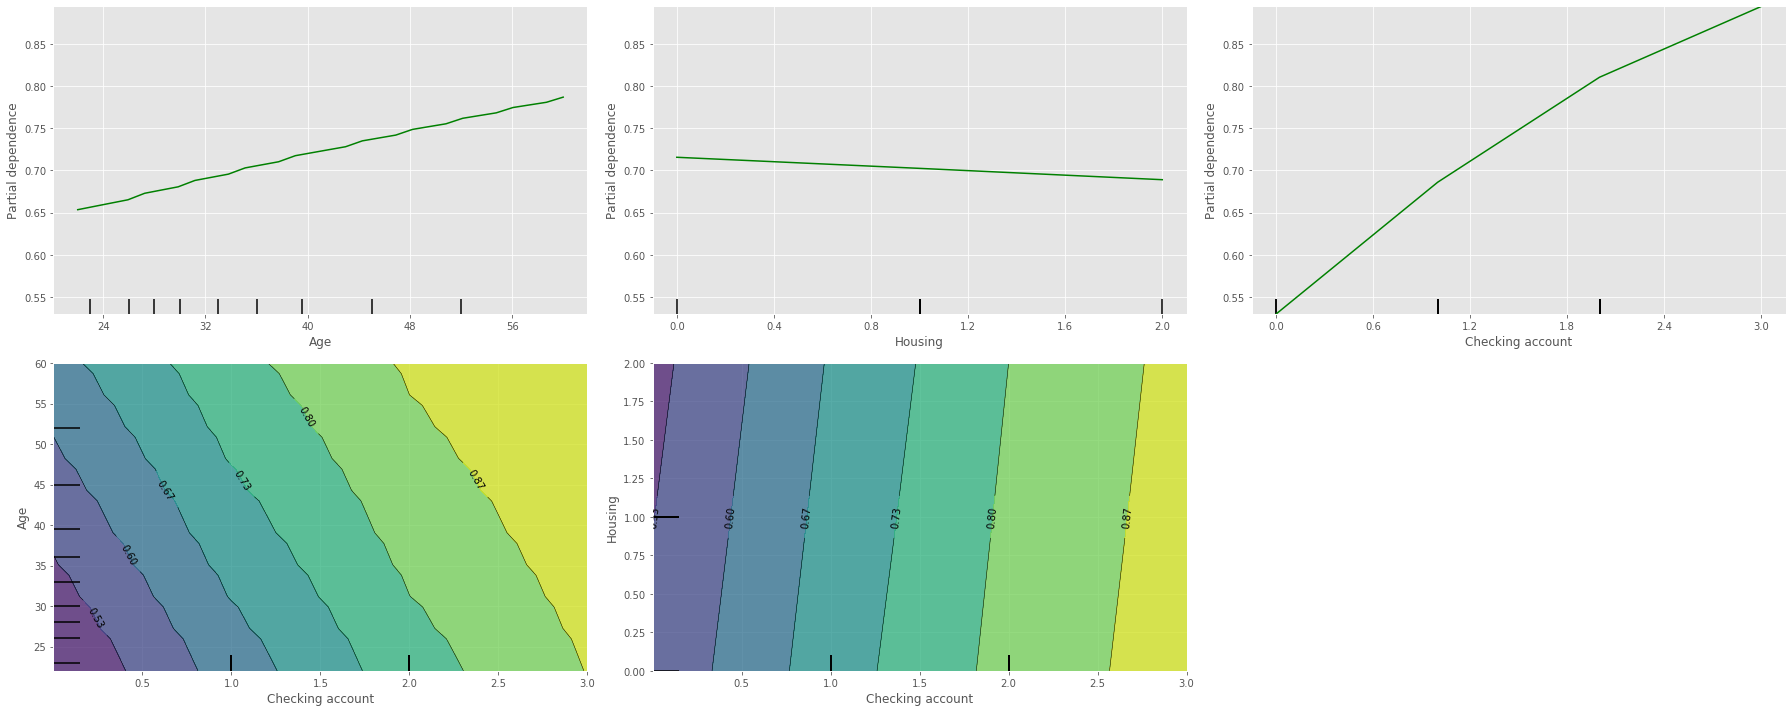

In [7]:
target_features = [0, 3, 5, (5, 0), (5, 3)]
fig = plot_partial_dependence(model, X_train, target_features,
                                    feature_names=feature_names,
                                    grid_resolution=30)
plt.tight_layout()

## pdpbox.info_plots

/home/alicia/workspace/ml_bias/venv/lib/python3.7/site-packages/pdpbox/info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction[:, 1]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


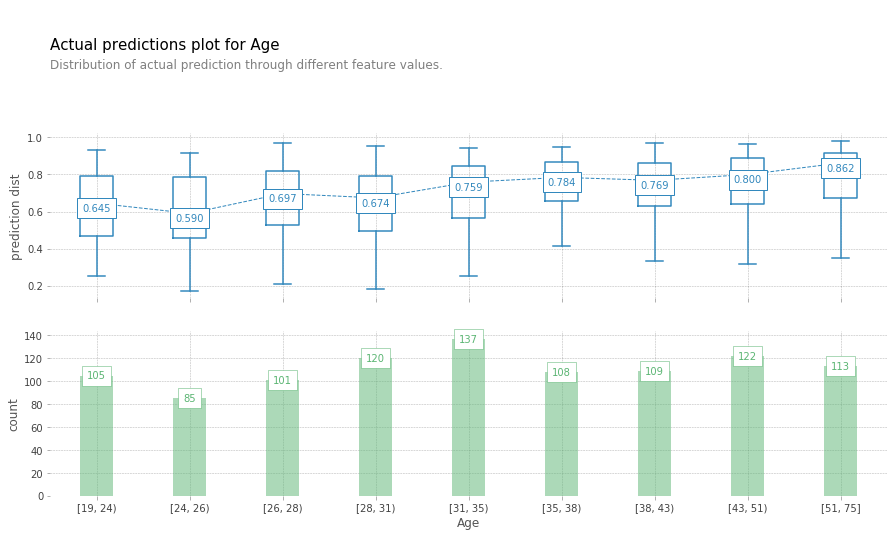

In [9]:
from pdpbox import info_plots

feature_name = 'Age'

fig, axes, summary_df = info_plots.actual_plot(
    model=model, 
    X=X,
    feature=feature_name, 
    feature_name=feature_name,
    predict_kwds={}
) 

# FairML

In [10]:
from fairml import audit_model

importances, _ = audit_model(model.predict, X)
print(importances)

Feature: Age,	 Importance: 0.313
Feature: Sex,	 Importance: 0.255
Feature: Job,	 Importance: -0.296
Feature: Housing,	 Importance: -0.169
Feature: Saving accounts,	 Importance: 0.186
Feature: Checking account,	 Importance: 0.367
Feature: Credit amount,	 Importance: -0.147
Feature: Duration,	 Importance: -0.193
Feature: Purpose,	 Importance: 0.251


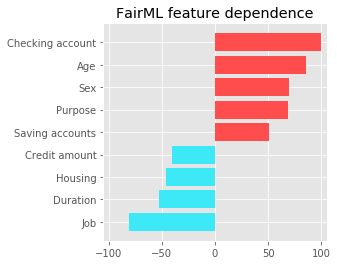

In [11]:
from fairml import plot_dependencies

# generate feature dependence plot
fig = plot_dependencies(
    importances.median(),
    reverse_values=False,
    title="FairML feature dependence"
)
plt.show()

# LIME

In [12]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X, 
                                                   feature_names=feature_names, 
                                                   class_names=['Good', 'Bad'] , 
                                                   discretize_continuous=False)

In [13]:
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X.values[i], model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=True)